In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
from gfcat_utils import parse_lightcurves_csv,parse_exposure_time,read_image
from matplotlib import gridspec
from astropy.visualization import ZScaleInterval
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.interpolate import interp1d
from astropy.stats import sigma_clip
from function_defs import *
import tqdm
from matplotlib import gridspec


In [2]:
tbl = pd.read_csv('gfcat_visit_table_lcstats.csv',index_col=None)
#print(tbl.keys())
ftbl = tbl[tbl['morphology']=='F'][['eclipse','obj_id','ra','dec','simbad_otype',
                                    'distance','distance_err','gaia_parallax_over_err','datetime_iso',
                                    'ratio_min','ratio_max']]
ftbl

,eclipse,obj_id,ra,dec,simbad_otype,distance,distance_err,gaia_parallax_over_err,datetime_iso,ratio_min,ratio_max
5,28486,1114928486.0,2.706065,-0.648669,--,220.6297574442524,7063.104343214374,32.01338195800781,2008-08-30T04:14:56,0.16312228705854662,1.9041147457574714
8,12799,--,2.921885,-28.352709,--,671.4528536379669,71873.22316994822,107.0413589477539,2005-09-20T23:32:07,--,--
17,23279,503423279.0,4.343351,16.509805,"Star, X",80.93024782923435,2914.536238231128,36.012939453125,2007-09-08T15:17:33,0.006074252600146832,0.10438522487933613
18,23300,1054723300.0,4.597080,16.862297,--,168.9524198050179,21099.932872717556,124.8868408203125,2007-09-10T01:48:15,0.433037810893797,2.188773510223216
19,23279,99999923279.0,4.654980,16.341350,"Galaxy, QSO, Star",1892.8887394777248,42265.92525272755,22.32879638671875,2007-09-08T15:17:33,0.7961207908254873,1.012469831911167
...,...,...,...,...,...,...,...,...,...,...,...
2345,23358,253223358.0,358.980921,-13.356852,"Eruptive*, Galaxy",23.24166538741304,30768.177390187648,1323.8370361328125,2007-09-14T01:06:27,0.13868228085589757,0.9688918392767724
2347,44465,786144465.0,359.256526,-55.897952,--,2417.361557307671,4678.790733481013,1.9354947805404663,2011-08-29T04:34:16,--,--
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,1.1769504025262172
2351,28525,1509128525.0,359.491560,-3.689567,EclBin_Candidate,321.7509414118013,33514.57897627484,104.1631088256836,2008-09-01T20:20:10,0.03201469195126219,1.4465755516462848


In [16]:
flare_table = pd.DataFrame({})
for visit in tqdm.tqdm(ftbl.iterrows()):
    visit = visit[1]
    e = visit['eclipse']
    edir = str(e).zfill(5)
    epath = f"../data/lightcurves/e{edir}"
    ra,dec = visit['ra'],visit['dec']
    distance = np.nan if visit['distance']=='--' else float(visit['distance'])#*1000
    distance_quality_metric = np.nan if visit['gaia_parallax_over_err']=='--' else float(visit['gaia_parallax_over_err'])
    obs = {}
    for band in ['NUV','FUV']:
        fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
        try:
            expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
            lcs = parse_lightcurves_csv(fn)
            # a few eclipse have multiple variables, so we have to pick the right one
            ix = np.argmin(angularSeparation(ra,dec,
                           np.array([lc['ra'] for lc in lcs]),
                           np.array([lc['dec'] for lc in lcs])))
            lc = pd.DataFrame({**lcs[ix],**expt}).rename(columns = {'expt_eff':'expt'})
            lc['cps_apcorrected']=mag2counts(counts2mag(lc['cps'],band)-apcorrect1(17.5/60/60,band),band)
        except FileNotFoundError:
            continue
        obs[band] = [lc,expt]
    if not len(obs):
        #print(f"Missing data for e{e}")
        continue
    
    band = 'NUV' if 'NUV' in obs.keys() else 'FUV' 
    lc = obs[band][0]
    # Measure flares
    (flare_ranges, quiescence, quiescence_err) = refine_flare_ranges(lc,makeplot=False)
    for flare_range in flare_ranges:
        v = visit.copy()
        energy = calculate_flare_energy(lc, flare_range, distance, binsize=30, band=band,
                       quiescence=[quiescence, quiescence_err], aperture=17.5)
        if len(obs.keys())==2:
            # because sometimes FUV visits are shorter, make the range fit
            fr = list(set(flare_range).intersection(range(len(obs['FUV'][0]))))
            energy_fuv = calculate_flare_energy(obs['FUV'][0], fr, distance, binsize=30,
                                                band='FUV', aperture=17.5)
            quiescence_fuv, quiescence_err_fuv = get_inff(obs['FUV'][0])
        else:
            energy_fuv = (np.nan, np.nan)
        #print(visit['eclipse'],band,energy,distance/1000)
        if distance_quality_metric>=100: # decline to record energies for low quality measurements
            v[f'energy_{band}'] = np.log10(energy[0])
            v[f'energy_err_{band}'] = np.log10(energy[1])
            if len(obs.keys())==2:
                v['energy_FUV'] = np.log10(energy_fuv[0])
                v['energy_err_FUV'] = np.log10(energy_fuv[1])
        
        v['duration'] = int(np.array(obs['NUV'][1]['t0'])[flare_range].max()-
                            np.array(obs['NUV'][1]['t0'])[flare_range].min())
        v['left_censored'] = int(is_left_censored(flare_range))
        v['right_censored'] = int(is_right_censored(lc,flare_range))
        v[f'peak_cps_{band}'] = peak_cps(lc,flare_range)
        v[f'peak_t0_{band}'] = int(peak_time(lc,flare_range))
        v['peak_censored'] = int(is_peak_censored(lc,flare_range))
        v[f'quiescence_{band}'] = quiescence
        v[f'quiescence_err_{band}'] = quiescence_err
        if len(obs.keys())==2:
            v['peak_cps_FUV'] = peak_cps(obs['FUV'][0],fr)
            v['peak_t0_FUV'] = int(peak_time(obs['FUV'][0],fr))
            v['quiescence_FUV'] = quiescence_fuv
            v['quiescence_err_FUV'] = quiescence_err_fuv

        flare_table = pd.concat([flare_table,v.to_frame().T])
flare_table.replace(np.nan, '--', inplace=True)
flare_table.to_csv('flare_table.csv',index=None)
flare_table

1082it [00:39, 27.21it/s]


,eclipse,obj_id,ra,dec,simbad_otype,distance,distance_err,gaia_parallax_over_err,datetime_iso,ratio_min,...,quiescence_NUV,quiescence_err_NUV,peak_cps_FUV,peak_t0_FUV,quiescence_FUV,quiescence_err_FUV,energy_NUV,energy_err_NUV,energy_FUV,energy_err_FUV
5,28486,1114928486.0,2.706065,-0.648669,--,220.6297574442524,7063.104343214374,32.01338195800781,2008-08-30T04:14:56,0.16312228705854662,...,1.246492,0.040312,0.141988,904119362,0.164976,0.010487,--,--,--,--
8,12799,--,2.921885,-28.352709,--,671.4528536379669,71873.22316994822,107.0413589477539,2005-09-20T23:32:07,--,...,5.174385,0.076231,--,--,--,--,32.885074,32.394492,--,--
17,23279,503423279.0,4.343351,16.509805,"Star, X",80.93024782923435,2914.536238231128,36.012939453125,2007-09-08T15:17:33,0.006074252600146832,...,304.984567,0.636736,0.912647,873314379,0.612882,0.019821,--,--,--,--
18,23300,1054723300.0,4.597080,16.862297,--,168.9524198050179,21099.932872717556,124.8868408203125,2007-09-10T01:48:15,0.433037810893797,...,1.678264,0.046077,0.21133,873438951,0.286631,0.013964,32.462897,31.31259,31.827307,31.229162
21,18248,--,4.662493,-10.071283,Star,153.16891600902687,3980.9924709265765,25.99086570739746,2006-09-29T03:05:55,0.0997859320117755,...,2.060785,0.071162,0.0,843548851,0.146078,0.010767,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,44465,786144465.0,359.256526,-55.897952,--,2417.361557307671,4678.790733481013,1.9354947805404663,2011-08-29T04:34:16,--,...,1.003541,0.030880,--,--,--,--,--,--,--,--
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,...,2.894415,0.050903,0.256224,904563040,0.274642,0.012902,30.202094,29.339045,29.661106,29.166519
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,...,2.894415,0.050903,0.256224,904563040,0.274642,0.012902,29.998729,29.256098,29.649717,29.152442
2351,28525,1509128525.0,359.491560,-3.689567,EclBin_Candidate,321.7509414118013,33514.57897627484,104.1631088256836,2008-09-01T20:20:10,0.03201469195126219,...,1.400088,0.047373,0.106365,904350136,0.146837,0.00961,33.450131,32.010491,32.980656,31.915083


In [54]:
print(flare_table.loc[flare_table['energy_NUV']!='--'].astype({'energy_NUV':float}).iloc[:20][['eclipse','ra','dec','energy_NUV']].to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 eclipse &        ra &        dec &  energy\_NUV \\
\midrule
   12799 &  2.921885 & -28.352709 &   32.885074 \\
   23300 &  4.597080 &  16.862297 &   32.462897 \\
   23288 &  5.297638 &  -8.695147 &   32.500955 \\
    7521 &  5.435448 &  15.727405 &   31.537223 \\
    7665 &  6.268810 & -36.772055 &   31.716732 \\
    7940 &  6.434150 &  17.081390 &   32.009424 \\
   13511 &  6.717086 &  42.833889 &   31.591763 \\
   44690 &  7.666082 & -38.166406 &   31.035472 \\
   44690 &  7.666082 & -38.166406 &   30.133739 \\
    7518 &  8.544446 & -44.084075 &   31.496422 \\
   12661 &  9.015684 & -41.943017 &   33.260642 \\
    7615 &  9.024228 & -43.578601 &   31.528995 \\
   33691 &  9.149622 &  42.304798 &   32.339494 \\
   44133 &  9.268403 &  42.410153 &   32.004868 \\
    7500 &  9.866419 & -44.522532 &   31.836185 \\
   23519 & 10.288136 &  41.927095 &   32.353167 \\
    8565 & 10.621016 & -44.415991 &   31.621009 \\
    7416 & 10.621032 & -44.415992 &   33.133219 \\
    7927 & 10.621199 & -44.415989 &   32.357987 \\
   13476 & 10.701904 &  35.548553 &   31.482776 \\
\bottomrule
\end{tabular}

[]

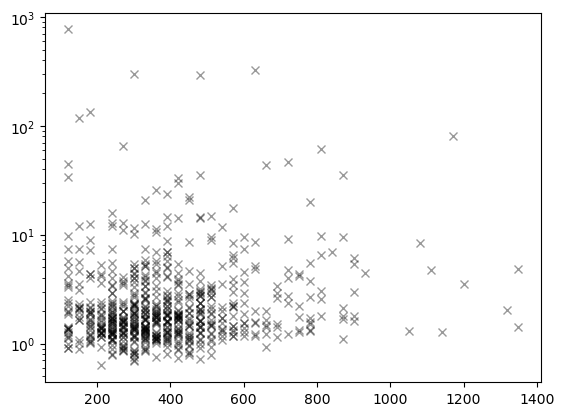

In [27]:
uncensored = flare_table.loc[(flare_table['peak_cps_NUV']!='--') &
                             (flare_table['right_censored']==0) &
                             (flare_table['left_censored']==0)]
plt.plot(uncensored['duration'],uncensored['peak_cps_NUV'],'kx',alpha=0.4)
plt.semilogy()

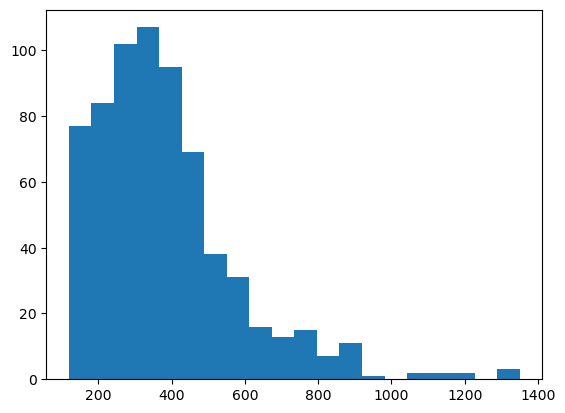

In [30]:
plt.hist(uncensored['duration'],bins=20);

In [26]:
uncensored.loc[uncensored['peak_cps_NUV']>600]

,eclipse,obj_id,ra,dec,simbad_otype,distance,distance_err,gaia_parallax_over_err,datetime_iso,ratio_min,...,quiescence_NUV,quiescence_err_NUV,peak_cps_FUV,peak_t0_FUV,quiescence_FUV,quiescence_err_FUV,energy_NUV,energy_err_NUV,energy_FUV,energy_err_FUV
1594,15128,592415128.0,219.750919,64.290383,"BYDraV*, Star",34.404388048325885,46175.512750989205,1342.1402587890625,2006-02-27T10:22:27,0.02285360851147119,...,700.372378,0.741539,3.697766,825089043,3.337114,0.044176,32.201917,30.862054,30.334892,30.052529


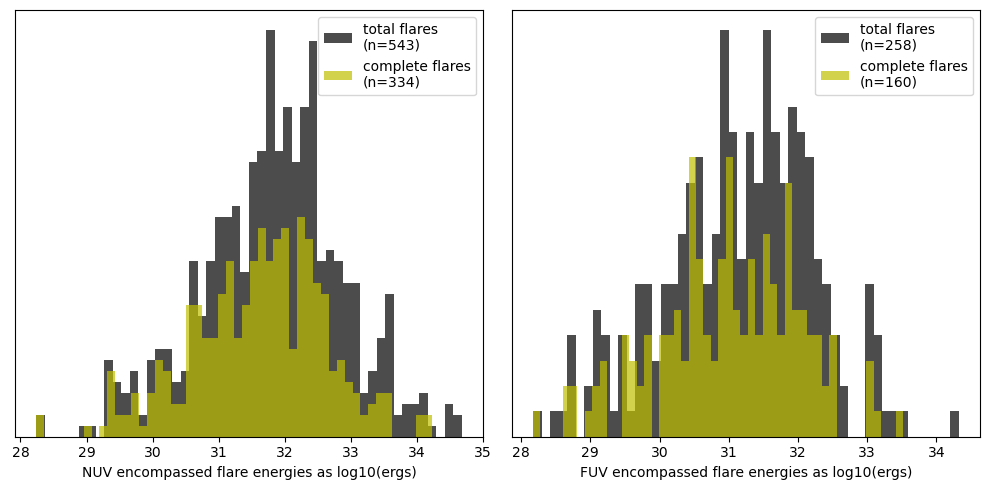

In [39]:
gs = gridspec.GridSpec(nrows=2, ncols=4)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(gs[:,:2])
flares_all = flare_table.loc[flare_table['energy_NUV']!='--']
flares_complete = flare_table.loc[(flare_table['energy_NUV']!='--') &
                                  (flare_table['left_censored']==0) &
                                  (flare_table['right_censored']==0)]
ax.hist(flares_all['energy_NUV'],bins=50,label=f"total flares\n(n={len(flares_all)})",color='k',alpha=0.7)
ax.hist(flares_complete['energy_NUV'],bins=50,label=f"complete flares\n(n={len(flares_complete)})",color='y',alpha=0.7)
ax.set_yticks([])
ax.set_xlabel('NUV encompassed flare energies as log10(ergs)')
ax.legend()

ax = fig.add_subplot(gs[:,2:])
flares_all = flare_table.loc[flare_table['energy_FUV']!='--']
flares_complete = flare_table.loc[(flare_table['energy_FUV']!='--') &
                                  (flare_table['left_censored']==0) &
                                  (flare_table['right_censored']==0)]
ax.hist(flares_all['energy_FUV'],bins=50,label=f"total flares\n(n={len(flares_all)})",color='k',alpha=0.7)
ax.hist(flares_complete['energy_FUV'],bins=50,label=f"complete flares\n(n={len(flares_complete)})",color='y',alpha=0.7)
ax.set_yticks([])
ax.set_xlabel('FUV encompassed flare energies as log10(ergs)')
ax.legend()
plt.tight_layout()
plt.savefig('flare_energy_dist.png',dpi=150)
plt.savefig('flare_energy_dist.pdf',dpi=150)

In [7]:
flare_table.loc[flare_table['left_censored']==0]

,eclipse,obj_id,ra,dec,simbad_otype,distance,distance_err,gaia_parallax_over_err,datetime_iso,ratio_min,...,quiescence_NUV,quiescence_err_NUV,peak_cps_FUV,peak_t0_FUV,quiescence_FUV,quiescence_err_FUV,energy_NUV,energy_err_NUV,energy_FUV,energy_err_FUV
5,28486,1114928486.0,2.706065,-0.648669,--,220.6297574442524,7063.104343214374,32.01338195800781,2008-08-30T04:14:56,0.16312228705854662,...,1.246492,0.040312,0.141988,904119362,0.164976,0.010487,--,--,--,--
8,12799,--,2.921885,-28.352709,--,671.4528536379669,71873.22316994822,107.0413589477539,2005-09-20T23:32:07,--,...,5.174385,0.076231,--,--,--,--,32.885074,32.394492,--,--
17,23279,503423279.0,4.343351,16.509805,"Star, X",80.93024782923435,2914.536238231128,36.012939453125,2007-09-08T15:17:33,0.006074252600146832,...,304.984567,0.636736,0.912647,873314379,0.612882,0.019821,--,--,--,--
18,23300,1054723300.0,4.597080,16.862297,--,168.9524198050179,21099.932872717556,124.8868408203125,2007-09-10T01:48:15,0.433037810893797,...,1.678264,0.046077,0.21133,873438951,0.286631,0.013964,32.462897,31.31259,31.827307,31.229162
21,18248,--,4.662493,-10.071283,Star,153.16891600902687,3980.9924709265765,25.99086570739746,2006-09-29T03:05:55,0.0997859320117755,...,2.060785,0.071162,0.0,843548851,0.146078,0.010767,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2347,44465,786144465.0,359.256526,-55.897952,--,2417.361557307671,4678.790733481013,1.9354947805404663,2011-08-29T04:34:16,--,...,1.003541,0.030880,--,--,--,--,--,--,--,--
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,...,2.894415,0.050903,0.256224,904563040,0.274642,0.012902,30.202094,29.339045,29.661106,29.166519
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,...,2.894415,0.050903,0.256224,904563040,0.274642,0.012902,29.998729,29.256098,29.649717,29.152442
2351,28525,1509128525.0,359.491560,-3.689567,EclBin_Candidate,321.7509414118013,33514.57897627484,104.1631088256836,2008-09-01T20:20:10,0.03201469195126219,...,1.400088,0.047373,0.106365,904350136,0.146837,0.00961,33.450131,32.010491,32.980656,31.915083


In [8]:
flare_table.loc[(flare_table['energy_NUV']!='--') & (flare_table['left_censored']==0) & (flare_table['right_censored']==0)]

,eclipse,obj_id,ra,dec,simbad_otype,distance,distance_err,gaia_parallax_over_err,datetime_iso,ratio_min,...,quiescence_NUV,quiescence_err_NUV,peak_cps_FUV,peak_t0_FUV,quiescence_FUV,quiescence_err_FUV,energy_NUV,energy_err_NUV,energy_FUV,energy_err_FUV
8,12799,--,2.921885,-28.352709,--,671.4528536379669,71873.22316994822,107.0413589477539,2005-09-20T23:32:07,--,...,5.174385,0.076231,--,--,--,--,32.885074,32.394492,--,--
18,23300,1054723300.0,4.597080,16.862297,--,168.9524198050179,21099.932872717556,124.8868408203125,2007-09-10T01:48:15,0.433037810893797,...,1.678264,0.046077,0.21133,873438951,0.286631,0.013964,32.462897,31.31259,31.827307,31.229162
31,23288,783723288.0,5.297638,-8.695147,X,37.892016327350184,22725.96253200496,599.7559204101562,2007-09-09T06:05:00,0.04800157009055585,...,1.979391,0.056065,0.047325,873367597,0.226424,0.012048,32.500955,30.503168,32.029112,30.423932
32,7521,--,5.435448,15.727405,--,57.788544677474015,34039.14733054018,589.029296875,2004-09-24T12:01:28,0.042068073744788784,...,1.614971,0.041367,0.045106,780077046,0.195177,0.010779,31.537223,30.385475,30.912506,30.26054
37,13511,2351913511.0,6.717086,42.833889,HighPM*,40.0193150390324,41679.09734750846,1041.4744873046875,2005-11-08T16:43:05,0.17239734867458228,...,6.345385,0.085547,0.338189,815521604,0.400743,0.015728,31.591763,30.348165,30.990945,30.122327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,7928,967807928.0,358.005170,16.336705,Star,91.05081769754727,28223.778694240165,309.97833251953125,2004-10-22T09:02:38,0.14365321541758694,...,1.282756,0.034965,0.411855,782485575,0.156646,0.010118,31.54622,30.61897,30.988678,30.502482
2336,18081,99999918081.0,358.469390,-10.544330,"GtowardsCl, Star",248.35958218941272,35254.45931675008,141.9492645263672,2006-09-17T16:41:01,0.037938764491295004,...,1.332357,0.038389,0.113828,842561107,0.129135,0.009012,32.712556,31.63234,32.085012,31.461262
2344,23351,1392923351.0,358.980788,-13.356872,"Eruptive*, Galaxy",23.24166538741304,30768.177390187648,1323.8370361328125,2007-09-13T13:36:22,0.11152029652989007,...,2.362837,0.044703,0.260386,873740308,0.163723,0.009872,30.333166,29.495393,29.808022,29.298717
2348,28561,587528561.0,359.336534,-12.980567,"**, Eruptive*",19.83195834898289,18432.442416868922,929.4312744140625,2008-09-04T07:29:08,0.1624842952806011,...,2.894415,0.050903,0.256224,904563040,0.274642,0.012902,30.202094,29.339045,29.661106,29.166519


        # Search for FUV flares, but use the NUV flare ranges rather than searching for new flare ranges
        # based on the FUV light curve (a good choice for GJ 65, but not necessarily the case in general).
        (flare_ranges_fuv, quiescence_fuv, quiescence_err_fuv) = refine_flare_ranges(lc_fuv, makeplot=False,
                                                                                 flare_ranges=flare_ranges)
        obs[band] = [lc,expt]
        find_flare_ranges(lc.rename(columns = {'expt_eff':'expt'}))
            for flare_range in flare_ranges:
        nuv_3sig = np.array(flare_range)[np.where((np.array(lc_nuv['cps'].iloc[flare_range].values)-
                             3*np.array(lc_nuv['cps_err'].iloc[flare_range].values) >= quiescence))[0]].tolist()
        fuv_3sig = np.array(flare_range)[np.where((np.array(lc_fuv['cps'].iloc[flare_range].values)-
                             3*np.array(lc_fuv['cps_err'].iloc[flare_range].values) >= quiescence_fuv))[0]].tolist()
        # Check that flux is simultaneously >3-sigma above quiescence in both bands (dual-band detection criteria),
        # or there are at least TWO NUV fluxes at >3-sigma above quiescence (single-band detection criteria).
        real = (any(set(nuv_3sig) & set(fuv_3sig)) or len(nuv_3sig)>1) # force detection conditions
        if not real:
            continue
        # Add a panel for the zoom-in view.  No visit has more than three real flares in it.
        n_found += 1
        flare_data = {'visit_num':i,'flare_num':len(flare_table)+1,'duration':len(flare_range)*30}
        # We pass the NUV quiescence values because we want to use the flare ranges found in the
        # NUV flare search for *both* NUV and FUV.  So we do NOT pass a quiescence parameter when
        # calling the FUV energy calculation.
        energy_nuv = calculate_flare_energy(lc_nuv, flare_range, distance, binsize=30, band='NUV',
                           quiescence=[quiescence, quiescence_err])
        energy_fuv = calculate_flare_energy(lc_fuv, flare_range, distance, binsize=30, band='FUV')
        nuv_sn = max(((np.array(lc_nuv['cps'].iloc[flare_range].values) -
                       3*np.array(lc_nuv['cps_err'].iloc[flare_range].values)) / quiescence))
        flare_data['energy_nuv'] = energy_nuv[0]
        flare_data['energy_err_nuv'] = energy_nuv[1]
        flare_data['energy_fuv'] = energy_fuv[0]
        flare_data['energy_err_fuv'] = energy_fuv[1]
        flare_data['nuv_sn'] = nuv_sn
        # If the flare is detected because it has at least one FUV and one NUV at the same time
        # above 3*INFF, this will be True.
        flare_data['detmeth_nf'] = any(set(nuv_3sig) & set(fuv_3sig))
        # If the flare is detected because it has at least two NUV fluxes that are both
        # above 3*INFF, this will be True.
        flare_data['detmeth_nn'] = len(nuv_3sig) > 1
        flare_data['left_censored'] = is_left_censored(flare_range)
        flare_data['right_censored'] = is_right_censored(lc_nuv,flare_range)
        flare_data['peak_flux_nuv'] = peak_flux(lc_nuv,flare_range)
        flare_data['peak_t0_nuv'] = peak_time(lc_nuv,flare_range)
        flare_data['peak_censored'] = is_peak_censored(lc_nuv,flare_range)
        flare_data['peak_flux_fuv'] = peak_flux(lc_fuv,flare_range)
        flare_data['peak_t0_fuv'] = peak_time(lc_fuv,flare_range)
        flare_data['quiescence_nuv'] = quiescence
        flare_data['quiescence_err_nuv'] = quiescence_err
        flare_data['quiescence_fuv'] = quiescence_fuv
        flare_data['quiescence_err_fuv'] = quiescence_err_fuv
        flare_data['flare_range'] = flare_range
        flare_table = flare_table.append(flare_data,ignore_index=True)

In [9]:
visit.copy()

eclipse                                 43796
obj_id                           2526043796.0
ra                                 359.854078
dec                                -74.912248
simbad_otype                               --
distance                   137.29710165965756
distance_err                59620.05585643592
gaia_parallax_over_err      434.2411804199219
datetime_iso              2011-07-14T09:23:19
ratio_min                                  --
ratio_max                                  --
Name: 2352, dtype: object

In [10]:
visit

eclipse                                 43796
obj_id                           2526043796.0
ra                                 359.854078
dec                                -74.912248
simbad_otype                               --
distance                   137.29710165965756
distance_err                59620.05585643592
gaia_parallax_over_err      434.2411804199219
datetime_iso              2011-07-14T09:23:19
ratio_min                                  --
ratio_max                                  --
Name: 2352, dtype: object